## Import

In [1]:
#@title Import modules
import os
import copy
import pickle
import secrets
import statistics
from time import time
import tqdm
os.environ['USE_FLASH_ATTENTION'] = '1'
import torch
torch.set_float32_matmul_precision('high')
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
torch.backends.cuda.enable_mem_efficient_sdp(True)
torch.backends.cuda.enable_math_sdp(True)
torch.backends.cuda.enable_flash_sdp(True)
torch.backends.cuda.enable_cudnn_sdp(True)
import TMIDIX
from midi_to_colab_audio import midi_to_colab_audio
from x_transformer_1_23_2 import *
import random
import matplotlib.pyplot as plt
from torchsummary import summary
from sklearn import metrics
from IPython.display import Audio, display
from huggingface_hub import hf_hub_download

import cv2
from my_utils import *

## Load Model

In [2]:
#@title Load Giant Music Transformer Pre-Trained Model
select_model_to_load = "482M-8L-Ultra-Fast-Medium" 
# @param ["482M-8L-Ultra-Fast-Medium","585M-32L-Very-Fast-Large","786M-44L-Fast-Extra-Large"]
model_precision = "bfloat16" # @param ["bfloat16", "float16"]
plot_tokens_embeddings = "None" 
full_path_to_models_dir = "./content/Giant-Music-Transformer/Models"

model_path, mdim, num_layers, mrpe = get_model_path(select_model_to_load, full_path_to_models_dir)

device_type = 'cuda'
if model_precision == 'bfloat16' and torch.cuda.is_bf16_supported():
  dtype = 'bfloat16'
else:
  dtype = 'float16'

if model_precision == 'float16':
  dtype = 'float16'
ptdtype = {'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = torch.amp.autocast(device_type=device_type, dtype=ptdtype)
SEQ_LEN = 2048
PAD_IDX = 19463
model = TransformerWrapper(
        num_tokens = PAD_IDX+1,
        max_seq_len = SEQ_LEN,
        attn_layers = Decoder(dim = mdim,
                              depth = num_layers,
                              heads = 32,
                              rotary_pos_emb = mrpe,
                              attn_flash = True
                              ),
        penalty_reward_tokens = True
)

model = AutoregressiveWrapper(model, ignore_index=PAD_IDX, pad_value=PAD_IDX)
model.load_state_dict(torch.load(model_path))
model.cuda()
model.eval()
print('Model summary...')
# summary(model)

Model already exists...
Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


/tmp/ipykernel_1424897/4234440750.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model summary...


## (LOAD SEED MIDI)

Loading seed MIDI...
Composition stats:
Composition has 348 notes
Composition has 1044 tokens
Composition MIDI patches: [0]


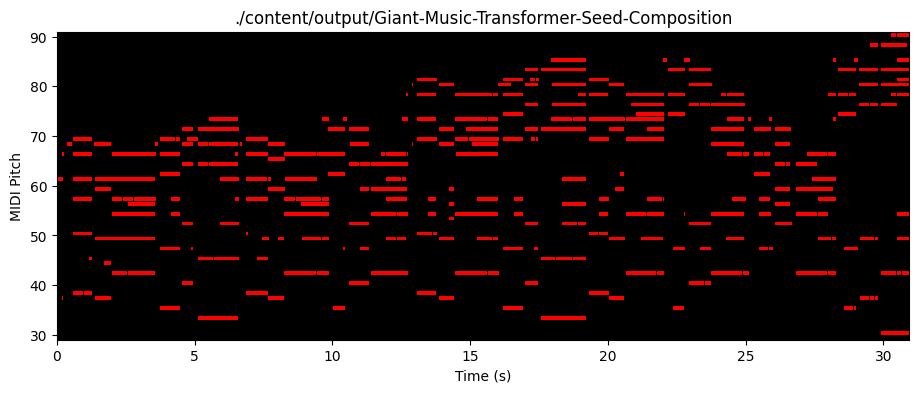

In [3]:
#@title Load Seed MIDI
select_seed_MIDI = "Giant-Music-Transformer-Piano-Seed-2" 
# @param ["Upload your own custom MIDI", "Giant-Music-Transformer-Piano-Seed-1", "Giant-Music-Transformer-Piano-Seed-2", "Giant-Music-Transformer-Piano-Seed-3", "Giant-Music-Transformer-Piano-Seed-4", "Giant-Music-Transformer-Piano-Seed-5", "Giant-Music-Transformer-Piano-Seed-6", "Giant-Music-Transformer-MI-Seed-1", "Giant-Music-Transformer-MI-Seed-2", "Giant-Music-Transformer-MI-Seed-3", "Giant-Music-Transformer-MI-Seed-4", "Giant-Music-Transformer-MI-Seed-5", "Giant-Music-Transformer-MI-Seed-6"]
number_of_prime_tokens = 8190 # @param {type:"slider", min:90, max:8190, step:3}
trim_all_outputs_to_last_chord = False # @param {type:"boolean"}
render_MIDI_to_audio = False # @param {type:"boolean"}

f = ''

if select_seed_MIDI != "Upload your own custom MIDI":
  print('Loading seed MIDI...')
  f = './Seeds/'+select_seed_MIDI+'.mid'

else:
  print('Upload your own custom MIDI...')
  print('=' * 70)
  uploaded_MIDI = files.upload()
  if list(uploaded_MIDI.keys()):
    f = list(uploaded_MIDI.keys())[0]

if f != '':

  score = TMIDIX.midi2single_track_ms_score(open(f, 'rb').read(), recalculate_channels=False)

  melody_chords_f = score2melody_chords_f(score, number_of_prime_tokens=number_of_prime_tokens, 
                                          trim_all_outputs_to_last_chord=trim_all_outputs_to_last_chord)

  song = melody_chords_f

  song_f, patches = melody_chords2song_f(song)

  #=======================================================

  print('=' * 70)
  print('Composition stats:')
  print('Composition has', int(len(melody_chords_f) / 3), 'notes')
  print('Composition has', len(melody_chords_f), 'tokens')
  print('Composition MIDI patches:', sorted(list(set([((y-2304) // 129) for y in melody_chords_f if 2304 <= y < 18945]))))
  print('=' * 70)

  fname = './content/output/Giant-Music-Transformer-Seed-Composition'

  block_lines = [(song_f[-1][1] / 1000)]
  block_tokens = [min(len(melody_chords_f), number_of_prime_tokens)]
  pblock = []

  if render_MIDI_to_audio:
    midi_audio = midi_to_colab_audio(fname + '.mid')
    display(Audio(midi_audio, rate=16000, normalize=False))

  TMIDIX.plot_ms_SONG(song_f, plot_title=fname)

else:
  print('=' * 70)

sum of image pixels: 3909270
sum of cvtColor pixels: 1303090
Image is too bright, inverting it
Image shape: (45, 116)
Image sum: 1303090
Image shape after cropping: (45, 36)
prompts shape: torch.Size([1, 1044])
img shape: (50, 80)
Generating sequence of max length: 1024
reward_penalty_mask shape: torch.Size([1, 1044, 19464])
sl: 0
img_px: 0 img_py: 14 ntime: 0 ndur: 0 npit: 108
in branch 4
sum in penalty_reward_mask: tensor(6., device='cuda:0')
logits shape: torch.Size([1, 19464])
logits: tensor([19.6250, 20.3750, 18.8750, 18.1250, 16.7500, 16.7500, 16.5000, 15.6875,
        15.5000, 16.0000, 17.6250, 19.1250, 19.8750, 19.0000, 17.5000, 16.6250,
        15.8125, 16.0000, 16.6250, 16.0000], device='cuda:0',
       dtype=torch.bfloat16)
arg max in logits: 24 with value: 20.75
arg min in logits: 1500 with value: -7.8125
sampled token: 25
0 / 1024
reward_penalty_mask shape: torch.Size([1, 1045, 19464])
sl: 1
img_px: 0 img_py: 14 ntime: 400 ndur: 0 npit: 108
in branch 3
in branch 5
sum in p

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable
fluidsynth: error: fluid_sfloader_load(): Failed to open '/usr/share/sounds/sf2/FluidR3_GM.sf2': File does not exist.
fluidsynth: error: Unable to open file '/usr/share/sounds/sf2/FluidR3_GM.sf2'
fluidsynth: error: ipatch_file_open() failed with error: 'No such file or directory'
fluidsynth: error: Failed to load SoundFont "/usr/share/sounds/sf2/FluidR3_GM.sf2"
fluidsynth: error: There is no preset with bank number 0 and preset number 0 in SoundFont -1
fluidsynth: error: There is no preset with bank number 0 and preset number 0 in SoundFont -1
fluidsynth: error: There is no preset with bank number 0 and preset number 0 in SoundFont -1
fluidsynth: error: There is no preset with bank number 0 and preset number 0 in SoundFont -1
fluidsynth: error: There is no preset with bank number 0 and preset number 0 in SoundFont -1
fluidsynth: error: There is no preset with bank number 0 and preset number 0 in SoundFont -1
f

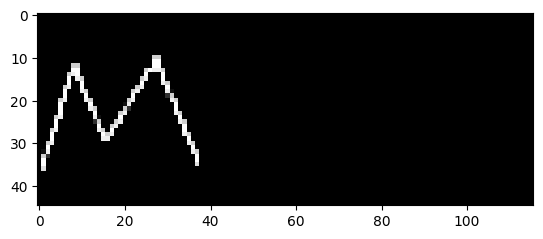

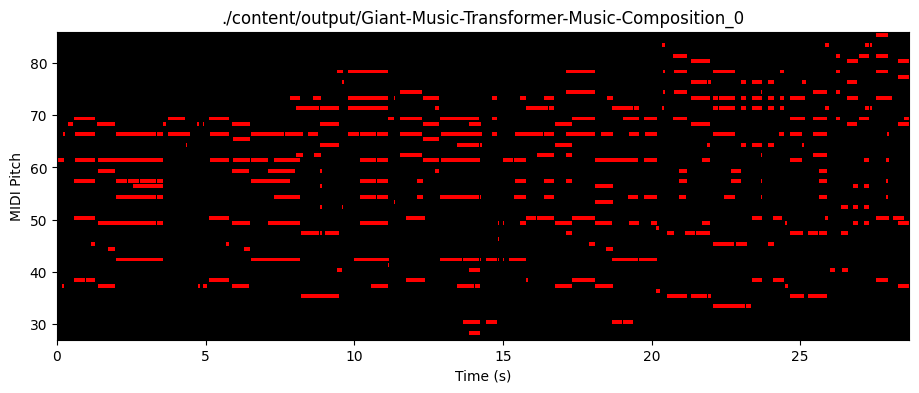

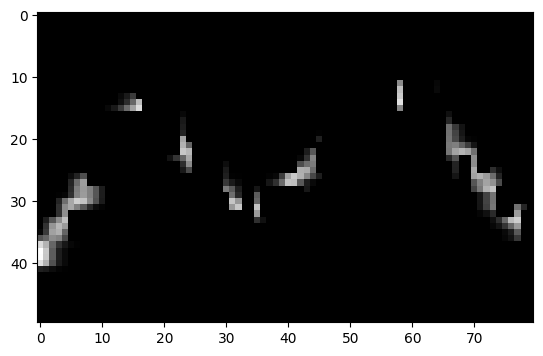

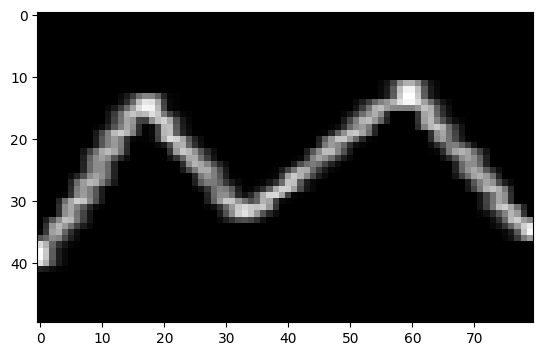

sum of outimg: 22151
sum of castedimg: 66936
ratio:  0.3309280506752719


In [5]:
#@title Standard Continuation Generator

#@markdown Generation settings

try_to_generate_outro = False #@param {type:"boolean"}
try_to_introduce_drums = False # @param {type:"boolean"}
number_of_tokens_to_generate = 1024 # @param {type:"slider", min:33, max:1024, step:3}
number_of_batches_to_generate = 1 #@param {type:"slider", min:1, max:16, step:1}
preview_length_in_tokens = 120 # @param {type:"slider", min:33, max:240, step:3}
number_of_memory_tokens = 8190 # @param {type:"slider", min:300, max:8190, step:3}
temperature = 1 # @param {type:"slider", min:0.1, max:1, step:0.05}
model_sampling_top_p_value = 0.96 # @param {type:"slider", min:0.1, max:1, step:0.01}

#@markdown Other settings

allow_model_to_stop_generation_if_needed = False #@param {type:"boolean"}
render_MIDI_to_audio = True # @param {type:"boolean"}

img = cv2.imread('./Seeds/pics/4.png')


out, outimg, castedimg = generate_with_img(
    model = model,
    melody_chords_f = melody_chords_f,
    img = img,
    ctx=ctx,
    number_of_tokens_to_generate = number_of_tokens_to_generate,
    number_of_batches_to_generate = number_of_batches_to_generate,
    number_of_memory_tokens = number_of_memory_tokens,
    temperature = temperature,
    model_sampling_top_p_value = model_sampling_top_p_value,
    try_to_generate_outro = try_to_generate_outro,
    try_to_introduce_drums = try_to_introduce_drums,
    allow_model_to_stop_generation_if_needed = allow_model_to_stop_generation_if_needed,
    try_RPM = True
    )
    
# out= generate_without_img(
#     model = model,
#     melody_chords_f = melody_chords_f,
#     # img = img,
#     ctx=ctx,
#     number_of_tokens_to_generate = number_of_tokens_to_generate,
#     number_of_batches_to_generate = number_of_batches_to_generate,
#     number_of_memory_tokens = number_of_memory_tokens,
#     temperature = temperature,
#     model_sampling_top_p_value = model_sampling_top_p_value,
#     try_to_generate_outro = try_to_generate_outro,
#     try_to_introduce_drums = try_to_introduce_drums,
#     allow_model_to_stop_generation_if_needed = allow_model_to_stop_generation_if_needed,
#     )

out0 = out.tolist()
# print(f"shape of out: {out.shape}")


torch.cuda.empty_cache()


for i in range(number_of_batches_to_generate):

  print('=' * 70)
  print('Batch #', i)
  print('=' * 70)

  out1 = trim_to_chord(out0[i],
                       enabled=trim_all_outputs_to_last_chord)


  if len(out) != 0:

      preview = melody_chords_f[:preview_length_in_tokens]
      song = preview + out1
      song_f, patches = melody_chords2song_f(song)

      patches = [0 if x==-1 else x for x in patches]

      detailed_stats = TMIDIX.Tegridy_ms_SONG_to_MIDI_Converter(song_f,
                                                          output_signature = 'Giant Music Transformer',
                                                          output_file_name = './content/output/Giant-Music-Transformer-Music-Composition_'+str(i),
                                                          track_name='Project Los Angeles',
                                                          list_of_MIDI_patches=patches
                                                          )

      fname = './content/output/Giant-Music-Transformer-Music-Composition_'+str(i)

      if render_MIDI_to_audio:
        midi_audio = midi_to_colab_audio(fname + '.mid')
        display(Audio(midi_audio, rate=16000, normalize=False))

      TMIDIX.plot_ms_SONG(song_f,
                          plot_title=fname,
                          preview_length_in_notes=0
                          )
      # plot image
      outimg = cv2.flip(outimg, 0)
      plt.imshow(outimg, cmap="gray")
      plt.show()
      castedimg = cv2.flip(castedimg, 0)
      plt.imshow(castedimg, cmap="gray")
      plt.show()

print("sum of outimg:", outimg.sum())
print("sum of castedimg:", castedimg.sum())
print("ratio: ", outimg.sum() / castedimg.sum())

In [ ]:
imgs_root_path = './Seeds/pics/'
imgs_path = os.listdir(imgs_root_path)
imgs_path = [os.path.join(imgs_root_path, img) for img in imgs_path if img.endswith('.png')]

prompt_imgs = []
for img_path in imgs_path:
    img = cv2.imread(img_path)
    prompt_imgs.append(img)


full_music = melody_chords_f




for i, img in enumerate(prompt_imgs):
    Fail  = True
    num_tries = 0
    while Fail:
        prompt_song = full_music[-number_of_memory_tokens+10:]
        out, outimg, castedimg= generate_with_img(
            model = model,
            melody_chords_f = prompt_song,
            img = img,
            ctx=ctx,
            number_of_tokens_to_generate = number_of_tokens_to_generate,
            number_of_batches_to_generate = number_of_batches_to_generate,
            number_of_memory_tokens = number_of_memory_tokens,
            temperature = temperature,
            model_sampling_top_p_value = model_sampling_top_p_value,
            try_to_generate_outro = try_to_generate_outro,
            try_to_introduce_drums = try_to_introduce_drums,
            allow_model_to_stop_generation_if_needed = allow_model_to_stop_generation_if_needed,
            )
        out0 = out.tolist()
        melody_chords_f = out0[0]
        melody_chords_f = trim_to_chord(melody_chords_f,
                                        enabled=trim_all_outputs_to_last_chord)
        
        


        song_f, patches = melody_chords2song_f(melody_chords_f)

        patches = [0 if x==-1 else x for x in patches]

        detailed_stats = TMIDIX.Tegridy_ms_SONG_to_MIDI_Converter(song_f,
                                                                output_signature = 'Giant Music Transformer',
                                                                output_file_name = './content/output/Giant-Music-Transformer-Music-Composition_'+str(i),
                                                                track_name='Project Los Angeles',
                                                                list_of_MIDI_patches=patches
                                                                )

        fname = './content/output/Giant-Music-Transformer-Music-Composition_'+str(i)

        
        midi_audio = midi_to_colab_audio(fname + '.mid')
        display(Audio(midi_audio, rate=16000, normalize=False))

        TMIDIX.plot_ms_SONG(song_f,
                            plot_title=fname,
                            preview_length_in_notes=0
                            )
        # plot image
        outimg = cv2.flip(outimg, 0)
        plt.imshow(outimg, cmap="gray")
        plt.show()
        castedimg = cv2.flip(castedimg, 0)
        plt.imshow(castedimg, cmap="gray")
        plt.show()

        print("sum of outimg:", outimg.sum())
        print("sum of castedimg:", castedimg.sum())
        print("ratio: ", outimg.sum() / castedimg.sum())

        if outimg.sum() / castedimg.sum() < 0.05:
            Fail = False
            full_music = full_music + melody_chords_f[-number_of_tokens_to_generate:]
        else:
            print("Image is not good enough, trying again...")
            num_tries += 1
            if num_tries > 10:
                print("Too many tries, stopping...")
                Fail = False
                # full_music = full_music + melody_chords_f[-number_of_tokens_to_generate:]
    

full_music_songf, patches = melody_chords2song_f(full_music)

TMIDIX.plot_ms_SONG(full_music_songf,
                    plot_title=fname,
                    preview_length_in_notes=0
                    )

In [ ]:

detailed_stats = TMIDIX.Tegridy_ms_SONG_to_MIDI_Converter(full_music_songf,
                                                    output_signature = 'Giant Music Transformer',
                                                    output_file_name = './content/output/full'
                                                    
                                                    ,
                                                    track_name='Project Los Angeles',
                                                    list_of_MIDI_patches=patches
                                                    )

if True:
  midi_audio = midi_to_colab_audio('./content/output/full.mid')
  display(Audio(midi_audio, rate=16000, normalize=False))
print('Done!')